# Fynd AML+ Interview Task

__Task:__ Build a model that automatically classifies a product’s pattern attribute based on its image.

<img src="aml.png">


__Approach used:__ The problem at hand is a texture classification problem. Here, I have used my knowledge of Transfer Learning to solve the problem. 

__Brief about Transfer Learning__

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems. [1]

__Tags:__ *Deep Learning, Transfer Learning, Texture Classification, Keras*

## Imports

In [196]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
from keras import models
from keras import layers
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import math  
import os, sys
import sklearn
import skimage
from skimage import io
import numpy as np
from collections import Counter
import numpy as np
import IPython.display as Disp
import matplotlib.pyplot as plt
import csv
%matplotlib inline
plt.style.use('ggplot')

## Helper functions

In [140]:
def get_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory)]
                      # if f.endswith(".jpg")]
        
        for f in file_names:
            images.append(f)
            labels.append(d)
    return images, labels

In [141]:
def load_image_using_keras(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    # (height, width, channels)
    img_tensor = image.img_to_array(img)                    
    # (1, height, width, channels), add a dimension because 
    # the model expects this shape: (batch_size, height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    # imshow expects values in the range [0, 1]
    img_tensor /= 255.                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


## Data Exploration

### Load data

In [74]:
# set path to project directory
ROOT_PATH = "/home/anuj/Desktop/transfer-learning/images"
train_data_directory = os.path.join(ROOT_PATH, "Train_Directory/") # train images path
test_data_directory = os.path.join(ROOT_PATH, "Test_Directory/") # test images path

# get image and label list 
images_list, labels_list = get_data(train_data_directory)

### Explore each category, count the number of sample images per category and display it with it's corresponding first image

In [75]:
images = np.array(images_list)
labels = np.array(labels_list)

# Get the unique labels 
unique_labels = set(labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # pick the first image for each label
    image = skimage.io.imread((images[labels_list.index(label)]))
    # Define subplots 
    plt.subplot(3, 4, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label: {0}, Count: {1}".format(label, labels_list.count(label)))
    i += 1
    # add plot
    plt.imshow(image)
    
# Show the plot
plt.show()

### Plot the count using bar plot

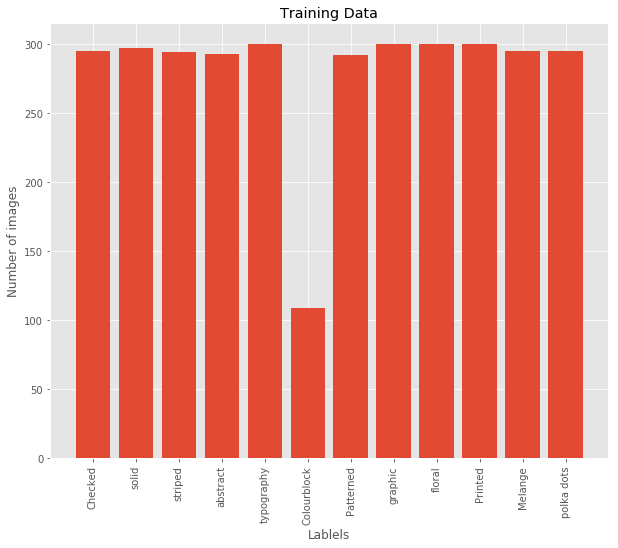

In [76]:
labels_dict = Counter(labels_list)

# Create a figure instance
fig = plt.figure(1, figsize=(10, 8))

# Create an axes instance
ax = fig.add_subplot(111)

# Create scatterplot
ax.bar(list(labels_dict.keys()), labels_dict.values())

# Set common labels
ax.set_xlabel('Lablels')
ax.set_ylabel('Number of images')
ax.set_title('Training Data');
plt.xticks(rotation=90)
# plt.bar(list(labels_dict.keys()), labels_dict.values())
plt.show()

### Observation
* It can be seen that for label 'Colourblock', the number of training images are lesser than the other images by approx 100. Although it is not in the magnitude of 10x or more but it might still affect the model.

* A general observation is that deep learning methods can still handle this much unbalance in the class, had it been more, then we might had to try getting more data for the category in question.

#### Note:
*On manually inspecting the data, it was found that there was an empty directory named "Predicted". Given the problem statement it clearly seemed that 'Predicted' was not a label. It was removed from the training image folder.*

### Keras data generator
* Using keras generator, load and split training and validation images

In [89]:
TRAINING_DIR = 'images/Train_Directory/'
TEST_DIR = 'images/Test_Directory/'
# VGG16 expects input to be of size 224x224 so we set it here
IMAGE_SIZE=224

# batch size 1 is taken given the GPU I am using has just 4GB VRM
BATCH_SIZE=1

# prepare data
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# load training data
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                     shuffle=True, seed=13, class_mode='categorical', 
                                                     batch_size=BATCH_SIZE, subset="training")

# load validation data
validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                          shuffle=True, seed=13, class_mode='categorical', 
                                                          batch_size=BATCH_SIZE, subset="validation")

Found 2699 images belonging to 12 classes.
Found 671 images belonging to 12 classes.


### Load VGG16 weights

In [5]:
model_vgg = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

### Print summary representation of the model

In [6]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Transfer Learning

* Freeze the non-trainable layers of the VGG16 network
* Display trainable layers

In [7]:
# Freeze the layers except the last 4 layers
for layer in model_vgg.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model_vgg.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd22b37de48> False
<keras.layers.convolutional.Conv2D object at 0x7fd22b32bb70> False
<keras.layers.convolutional.Conv2D object at 0x7fd22b32be80> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd22b32e780> False
<keras.layers.convolutional.Conv2D object at 0x7fd22b32eb38> False
<keras.layers.convolutional.Conv2D object at 0x7fd22829f438> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd2282d7588> False
<keras.layers.convolutional.Conv2D object at 0x7fd2282d7f60> False
<keras.layers.convolutional.Conv2D object at 0x7fd229b062b0> False
<keras.layers.convolutional.Conv2D object at 0x7fd229a9d2b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd229ab3160> False
<keras.layers.convolutional.Conv2D object at 0x7fd229ab3e48> False
<keras.layers.convolutional.Conv2D object at 0x7fd229a5d278> False
<keras.layers.convolutional.Conv2D object at 0x7fd229a738d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd229a8c390>

### Add essential layers
* Create computational graph
* Load VGG16 weights in the model
* Flatten the input, apply dense, dropout layers, and then the softmax classifier at the end

In [8]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(model_vgg)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                6156      
Total params: 27,566,412
Trainable params: 19,931,148
Non-trainable params: 7,635,264
_________________________________________________________________


### Compile the model
* Here, after understanding the problem statement, we try out various optimizers available in Keras and see which of them helps converge the model.
* In this case, Adagrad with learning rate: 1e-4 worked well. 
* Other optimizers experimented with: SGD, RMSProp - they didn't work.

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adagrad(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator( 
                              train_generator, 
                              steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                              epochs=20, 
                              verbose=True,
                                validation_data=validation_generator)
 
# Save the model
model.save('test_2.h5')

Epoch 1/20
2699/2699 [==============================] - 441s 163ms/step - loss: 1.8972 - acc: 0.3683 - val_loss: 1.4372 - val_acc: 0.5216
Epoch 2/20
2699/2699 [==============================] - 441s 164ms/step - loss: 1.2995 - acc: 0.5632 - val_loss: 1.2830 - val_acc: 0.5589
Epoch 3/20
2699/2699 [==============================] - 444s 165ms/step - loss: 1.0814 - acc: 0.6321 - val_loss: 1.2276 - val_acc: 0.5648
Epoch 4/20
2699/2699 [==============================] - 439s 163ms/step - loss: 0.9527 - acc: 0.6765 - val_loss: 1.1895 - val_acc: 0.5797
Epoch 5/20
2699/2699 [==============================] - 440s 163ms/step - loss: 0.8782 - acc: 0.6966 - val_loss: 1.1508 - val_acc: 0.5946
Epoch 6/20
2699/2699 [==============================] - 439s 163ms/step - loss: 0.8121 - acc: 0.7166 - val_loss: 1.1429 - val_acc: 0.5842
Epoch 7/20
2699/2699 [==============================] - 436s 162ms/step - loss: 0.7395 - acc: 0.7510 - val_loss: 1.1359 - val_acc: 0.6066
Epoch 8/20
2699/2699 [============

### Observation
* The model above has training accuracy of 90% in 20 epochs. 
* The validation accuracy however is stuck around 61% 
* ***Looking at the above statistics, it seems that on increasing the number of epochs, the training accuracy will definitely improve but not the validation accuracy - meaning that the model will tend to overfit the training dataset soon.***
* ***This made me re-check my training images once again, and here I found a lot of discrepancy. Images of one category/label was also present in the other category. If this happens, then the any model is bound to get confused and the accuracy is expected to plateau at some point, just as it happend above.***

#### Note:
The images that I have talked about are in 'discrepancy-observed' directory 

### Class label map by keras

In [83]:
label_map = (train_generator.class_indices)
label_map

{'Checked': 0,
 'Colourblock': 1,
 'Melange': 2,
 'Patterned': 3,
 'Printed': 4,
 'abstract': 5,
 'floral': 6,
 'graphic': 7,
 'polka dots': 8,
 'solid': 9,
 'striped': 10,
 'typography': 11}

### Predictions

In [187]:
img_path = '/home/anuj/Desktop/transfer-learning/images/Test_Directory/64783.jpg'
new_image = load_image_using_keras(img_path)

In [86]:
new_image.shape

(1, 224, 224, 3)

In [87]:
model.predict_classes(new_image)

array([4])

In [204]:
test_image_list = sorted(os.listdir(test_data_directory))
predictions = {}
for image_name in test_image_list:
    file = os.path.join(test_data_directory, image_name)
    test_image = load_image_using_keras(file)
    result = model.predict_classes(test_image)[0]
    pred_label_name = list(label_map.keys())[list(label_map.values()).index(result)]
    predictions[image_name] = pred_label_name

In [206]:
with open('results.csv', 'w') as f:
    for key, value in predictions.items():
        f.write("%s,%s\n"%(key, value))

## What was asked for and what could be achieved

### Evaluation Metric
1. Classification Accuracy(85+) - ***Could only reach validation accuracy of about 61%, reasons have already been stated above***
2. Confusion matrix table against Test data - ***Test data doesn't have labels so this metric cannot be generated***
3. Approach (relevant research paper studied, code and improvements suggested) - ***relevant information mentioned in the top section of this notebook/assignment and reference section is towards the end***
4. error free docker image / file which will run api - ***could not build a docker image due to time constraints***

# References
1. https://machinelearningmastery.com/transfer-learning-for-deep-learning/
2. https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/